In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load Dataset
df = pd.read_csv('dataset/XSS_dataset.csv', encoding='utf-8-sig')
df = df[df.columns[-2:]]  # Only get sentence and labels

In [3]:
# Get Sentences data from data frame
sentences = df['Sentence'].values
labels = df['Label'].values


In [4]:
# Convert to ASCII
def convert_to_ascii(sentence):
    sentence_ascii = []
    for char in sentence:
        if ord(char) < 8222:
            if ord(char) == 8217:  # ’
                sentence_ascii.append(134)
            elif ord(char) == 8221:  # ”
                sentence_ascii.append(129)
            elif ord(char) == 8220:  # “
                sentence_ascii.append(130)
            elif ord(char) == 8216:  # ‘
                sentence_ascii.append(131)
            elif ord(char) == 8211:  # –
                sentence_ascii.append(133)
            if ord(char) <= 128:
                sentence_ascii.append(ord(char))
    zer = np.zeros((10000,))
    for i in range(len(sentence_ascii)):
        zer[i] = sentence_ascii[i]
    zer.shape = (100, 100)
    return zer


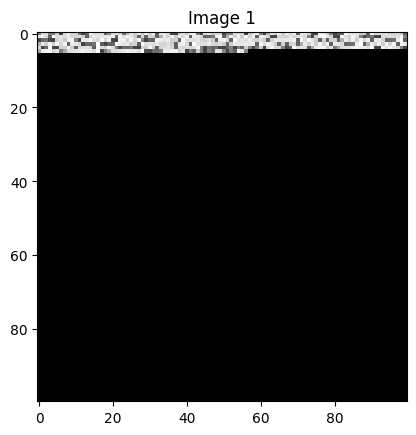

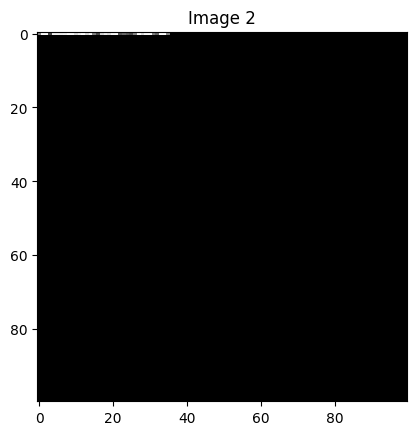

In [5]:
# Prepare Data
arr = np.zeros((len(sentences), 100, 100))
for i in range(len(sentences)):
    image = convert_to_ascii(sentences[i])
    x = np.asarray(image, dtype='float')
    image = cv2.resize(x, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
    image /= 128
    arr[i] = image

# Show the first two images in the data array
for i in range(2):
    plt.imshow(arr[i], cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.show()

In [6]:
# Reshape data for input to CNN
data = arr.reshape(arr.shape[0], 1, 100, 100)

In [7]:
# Create PyTorch Dataset
class XSSDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [8]:
# Split data: train 70%, verify 20%, test 10%
train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=0.3, random_state=42)
verify_data, test_data, verify_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=1/3, random_state=42)

train_dataset = XSSDataset(train_data, train_labels)
verify_dataset = XSSDataset(verify_data, verify_labels)
test_dataset = XSSDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
verify_loader = DataLoader(verify_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [9]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


In [10]:
# Train and test with different learning rates
learning_rates = [0.001, 0.002, 0.01, 0.02, 0.05]
num_epochs = 20
all_loss_train = []
all_loss_verify = []

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = CNNModel()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_train = []
    loss_verify = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_train.append(epoch_loss / len(train_loader))

        # Validation loss
        model.eval()
        verify_loss = 0
        with torch.no_grad():
            for inputs, labels in verify_loader:
                outputs = model(inputs.float())
                loss = criterion(outputs.squeeze(), labels.float())
                verify_loss += loss.item()
        loss_verify.append(verify_loss / len(verify_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_train[-1]:.4f}, Verify Loss: {loss_verify[-1]:.4f}")

    all_loss_train.append(loss_train)
    all_loss_verify.append(loss_verify)



Training with learning rate: 0.001


Epoch [1/20], Training Loss: 0.5137, Verify Loss: 0.4006


Epoch [2/20], Training Loss: 0.3527, Verify Loss: 0.2965


Epoch [3/20], Training Loss: 0.1560, Verify Loss: 0.1187


Epoch [4/20], Training Loss: 0.0949, Verify Loss: 0.0942


Epoch [5/20], Training Loss: 0.0884, Verify Loss: 0.0846


Epoch [6/20], Training Loss: 0.0684, Verify Loss: 0.0762


Epoch [7/20], Training Loss: 0.0597, Verify Loss: 0.0747


Epoch [8/20], Training Loss: 0.0502, Verify Loss: 0.0766


Epoch [9/20], Training Loss: 0.0469, Verify Loss: 0.0616


Epoch [10/20], Training Loss: 0.0400, Verify Loss: 0.0674


Epoch [11/20], Training Loss: 0.0365, Verify Loss: 0.0593


Epoch [12/20], Training Loss: 0.0310, Verify Loss: 0.0617


Epoch [13/20], Training Loss: 0.0293, Verify Loss: 0.0473


Epoch [14/20], Training Loss: 0.0245, Verify Loss: 0.0623


Epoch [15/20], Training Loss: 0.0303, Verify Loss: 0.0514


Epoch [16/20], Training Loss: 0.0232, Verify Loss: 0.0448


Epoch [17/20], Training Loss: 0.0192, Verify Loss: 0.0479


Epoch [18/20], Training Loss: 0.0154, Verify Loss: 0.0501


Epoch [19/20], Training Loss: 0.0132, Verify Loss: 0.0379


Epoch [20/20], Training Loss: 0.0147, Verify Loss: 0.0571

Training with learning rate: 0.002


Epoch [1/20], Training Loss: 0.5040, Verify Loss: 0.3735


Epoch [2/20], Training Loss: 0.2858, Verify Loss: 0.1324


Epoch [3/20], Training Loss: 0.1053, Verify Loss: 0.0958


Epoch [4/20], Training Loss: 0.0794, Verify Loss: 0.0945


Epoch [5/20], Training Loss: 0.0803, Verify Loss: 0.0887


Epoch [6/20], Training Loss: 0.0649, Verify Loss: 0.0708


Epoch [7/20], Training Loss: 0.0531, Verify Loss: 0.0603


Epoch [8/20], Training Loss: 0.0451, Verify Loss: 0.0600


Epoch [9/20], Training Loss: 0.0515, Verify Loss: 0.0557


Epoch [10/20], Training Loss: 0.0333, Verify Loss: 0.0553


Epoch [11/20], Training Loss: 0.0271, Verify Loss: 0.0480


Epoch [12/20], Training Loss: 0.0370, Verify Loss: 0.0540


Epoch [13/20], Training Loss: 0.0243, Verify Loss: 0.0531


Epoch [14/20], Training Loss: 0.0185, Verify Loss: 0.0534


Epoch [15/20], Training Loss: 0.0184, Verify Loss: 0.0493


Epoch [16/20], Training Loss: 0.0131, Verify Loss: 0.0490


Epoch [17/20], Training Loss: 0.0130, Verify Loss: 0.0520


Epoch [18/20], Training Loss: 0.0133, Verify Loss: 0.0437


Epoch [19/20], Training Loss: 0.0099, Verify Loss: 0.0500


Epoch [20/20], Training Loss: 0.0256, Verify Loss: 0.0730

Training with learning rate: 0.01


Epoch [1/20], Training Loss: 45.5972, Verify Loss: 45.5618


Epoch [2/20], Training Loss: 46.2110, Verify Loss: 45.5618


Epoch [3/20], Training Loss: 46.2072, Verify Loss: 45.5618


Epoch [4/20], Training Loss: 46.2072, Verify Loss: 45.5618


Epoch [5/20], Training Loss: 46.2149, Verify Loss: 45.5618


Epoch [6/20], Training Loss: 46.2110, Verify Loss: 45.5618


Epoch [7/20], Training Loss: 46.2110, Verify Loss: 45.5618


Epoch [8/20], Training Loss: 46.2207, Verify Loss: 45.5618


Epoch [9/20], Training Loss: 46.2303, Verify Loss: 45.5618


Epoch [10/20], Training Loss: 46.2091, Verify Loss: 45.5618


Epoch [11/20], Training Loss: 46.2052, Verify Loss: 45.5618


Epoch [12/20], Training Loss: 46.2110, Verify Loss: 45.5618


Epoch [13/20], Training Loss: 46.2110, Verify Loss: 45.5618


Epoch [14/20], Training Loss: 46.1975, Verify Loss: 45.5618


Epoch [15/20], Training Loss: 46.2052, Verify Loss: 45.5618


Epoch [16/20], Training Loss: 46.2226, Verify Loss: 45.5618


Epoch [17/20], Training Loss: 46.1995, Verify Loss: 45.5618


Epoch [18/20], Training Loss: 46.2014, Verify Loss: 45.5618


Epoch [19/20], Training Loss: 46.2052, Verify Loss: 45.5618


Epoch [20/20], Training Loss: 46.2188, Verify Loss: 45.5618

Training with learning rate: 0.02


Epoch [1/20], Training Loss: 45.6531, Verify Loss: 45.5618


Epoch [2/20], Training Loss: 46.1995, Verify Loss: 45.5618


Epoch [3/20], Training Loss: 46.2168, Verify Loss: 45.5618


Epoch [4/20], Training Loss: 46.2130, Verify Loss: 45.5618


Epoch [5/20], Training Loss: 46.2207, Verify Loss: 45.5618


Epoch [6/20], Training Loss: 46.2091, Verify Loss: 45.5618


Epoch [7/20], Training Loss: 46.2168, Verify Loss: 45.5618


Epoch [8/20], Training Loss: 46.2072, Verify Loss: 45.5618


Epoch [9/20], Training Loss: 46.2342, Verify Loss: 45.5618


Epoch [10/20], Training Loss: 46.2207, Verify Loss: 45.5618


Epoch [11/20], Training Loss: 46.2168, Verify Loss: 45.5618


Epoch [12/20], Training Loss: 46.2014, Verify Loss: 45.5618


Epoch [13/20], Training Loss: 46.2149, Verify Loss: 45.5618


Epoch [14/20], Training Loss: 46.1995, Verify Loss: 45.5618


Epoch [15/20], Training Loss: 46.1840, Verify Loss: 45.5618


Epoch [16/20], Training Loss: 46.2130, Verify Loss: 45.5618


Epoch [17/20], Training Loss: 46.2072, Verify Loss: 45.5618


Epoch [18/20], Training Loss: 46.2149, Verify Loss: 45.5618


Epoch [19/20], Training Loss: 46.2052, Verify Loss: 45.5618


Epoch [20/20], Training Loss: 46.2226, Verify Loss: 45.5618

Training with learning rate: 0.05


Epoch [1/20], Training Loss: 45.7146, Verify Loss: 45.5618


Epoch [2/20], Training Loss: 46.2052, Verify Loss: 45.5618


Epoch [3/20], Training Loss: 46.2091, Verify Loss: 45.5618


Epoch [4/20], Training Loss: 46.2188, Verify Loss: 45.5618


Epoch [5/20], Training Loss: 46.2072, Verify Loss: 45.5618


Epoch [6/20], Training Loss: 46.2033, Verify Loss: 45.5618


Epoch [7/20], Training Loss: 46.2091, Verify Loss: 45.5618


Epoch [8/20], Training Loss: 46.2168, Verify Loss: 45.5618


Epoch [9/20], Training Loss: 46.2188, Verify Loss: 45.5618


Epoch [10/20], Training Loss: 46.2110, Verify Loss: 45.5618


Epoch [11/20], Training Loss: 46.2110, Verify Loss: 45.5618


Epoch [12/20], Training Loss: 46.2168, Verify Loss: 45.5618


Epoch [13/20], Training Loss: 46.2149, Verify Loss: 45.5618


Epoch [14/20], Training Loss: 46.1763, Verify Loss: 45.5618


Epoch [15/20], Training Loss: 46.1763, Verify Loss: 45.5618


Epoch [16/20], Training Loss: 46.2245, Verify Loss: 45.5618


Epoch [17/20], Training Loss: 46.2188, Verify Loss: 45.5618


Epoch [18/20], Training Loss: 46.2149, Verify Loss: 45.5618


Epoch [19/20], Training Loss: 46.2303, Verify Loss: 45.5618


Epoch [20/20], Training Loss: 46.2188, Verify Loss: 45.5618


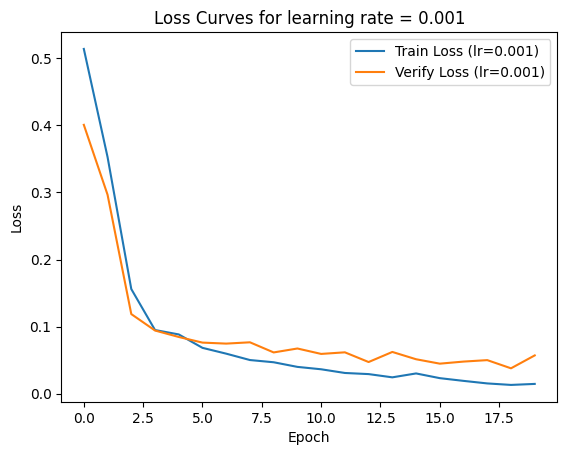

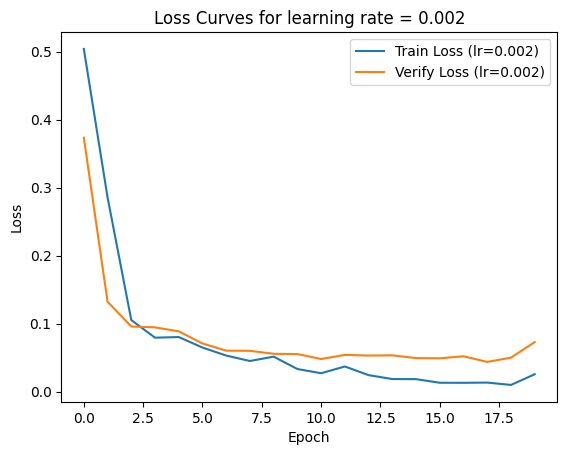

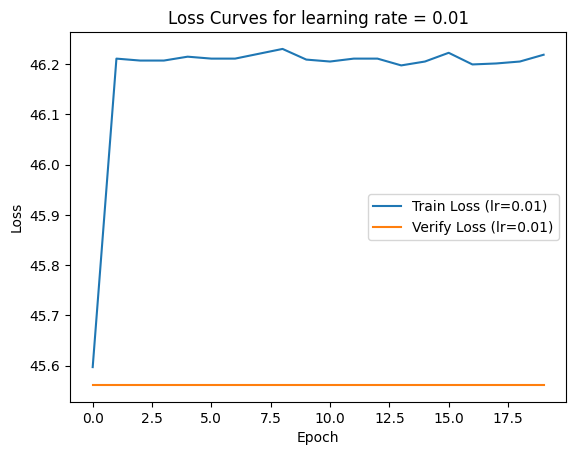

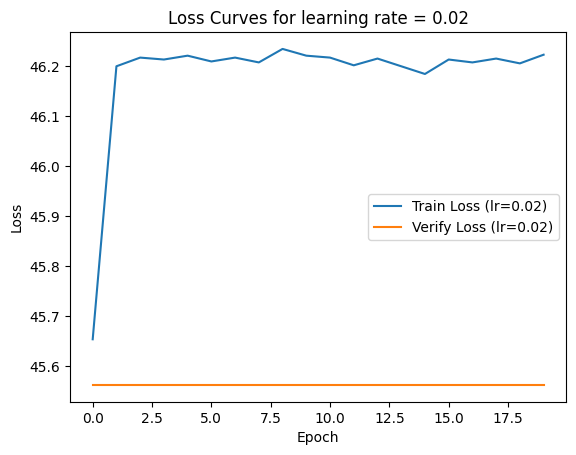

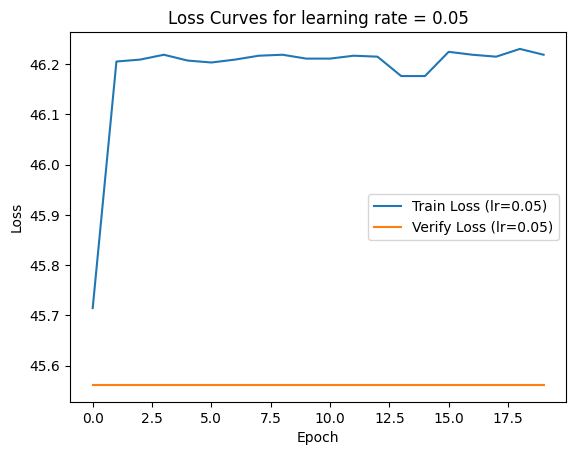

In [11]:
# Plot training and verify loss for each learning rate
for i, lr in enumerate(learning_rates):
    plt.plot(all_loss_train[i], label=f'Train Loss (lr={lr})')
    plt.plot(all_loss_verify[i], label=f'Verify Loss (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss Curves for learning rate = {lr}')
    plt.show()

In [12]:
# Prediction on test data
model.eval()
predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.float())
        predictions.extend(outputs.squeeze().round().numpy())

In [13]:
# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
confusion = confusion_matrix(test_labels, predictions)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix: \n", confusion)

Accuracy:  0.5383491599707816
Precision:  0.5383491599707816
Recall:  1.0
F1 Score:  0.6999050332383666
Confusion Matrix: 
 [[  0 632]
 [  0 737]]
